## MatchEd Analysis: Control Condition

This notebook examines data collected in condition ID 660af3a006227e71ec8eb992, which is the control arm intended to be a direct replication of Chen and Sönmez (2006). Reads data from the corresponding condition CSV file. Then, it enriches the data with bias classifications according to the 2006 paper. We look at rates of truthful preference revelation and patterns in the biases to compare to the original paper.

## Processing and Basic Analysis

Conduct some basic analysis on truth-telling behavior and classify preference manipulations into different types of bias. Pivots CSV data from 1 row per student-school combination into one row per student with columns for each submitted and truthful ranking. This should enable easier analysis for something like a logit regression later. Data output into file `control_processed.csv`.

In [337]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [182]:
# Read in the data
obj_id = "660af3a006227e71ec8eb992"
control_data = pd.read_csv(f'condition_{obj_id}.csv')
control_data.head()

,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district
0,1,0,2,13,5.0,True
1,1,1,1,16,1.0,False
2,1,2,4,9,2.0,False
3,1,3,7,2,7.0,False
4,1,4,6,5,3.0,False


In [183]:
# We didn't get data for all students. Get a list of ids with data, meaning submitted ran is not null
ids_with_data = control_data[control_data['submitted_rank'].notnull()]['student_id'].unique()
print("We got data for", len(ids_with_data), "students with ids", ids_with_data)

We got data for 28 students with ids [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 34 36]


In [184]:
# Filter out those rows where submitted_rank is empty, and cast submitted rank to int
control_data = control_data.loc[control_data['submitted_rank'].notnull()]
control_data['submitted_rank'] = control_data['submitted_rank'].astype(int)

In [185]:
control_data['correct'] = control_data['submitted_rank'] == control_data['truthful_rank']
# Group by student id and return number of students who got all correct
grouped_students = control_data.groupby('student_id')['correct'].sum()
correct_students = grouped_students[grouped_students == 7]
# Add a column to the dataframe to indicate if the student is correct
control_data['complete_truthtell'] = control_data['student_id'].isin(correct_students.index)
print("The number of students who ranked all preferences completely truthfully is", correct_students.shape[0], "out of", control_data['student_id'].nunique(), ". The ids are:", correct_students.index.values)

The number of students who ranked all preferences completely truthfully is 8 out of 28 . The ids are: [ 7 15 16 17 18 19 24 25]


Of the results collected, a very small percentage reported entirely truthfully. We only observe 7 total participants reporting truthfully. We will first qualify this result by following Chen and Sönmez's method: "Under GS, truthful preference revelation requires that the reported ranking is identical to the true preference ranking from the first choice up to the participant's district school. The remaining rankings, from the district school to the last choice, are irrelevant under both GS and TTC." We are also interested in seeing if having your district school as your first preference predicts truthful preference revelation (as we hypothesize it should). There are only two instances in the data where the district school is also the top choice. In our results, 1 of the 2 participants reported truthfully. This is obviously non-optimal play because the DA algorithm guarantees participants a school at least as desirable as their district school.

In [186]:
groups = control_data.groupby('student_id')
count = 0
chen_sonmez_truthful = []
for _, group in groups:
    sorted_group = group.sort_values('truthful_rank')
    district_index = sorted_group[sorted_group['is_district']].index[0]

    # Check if series are equal up to and including the district index
    if (sorted_group.loc[:district_index, 'truthful_rank'] == sorted_group.loc[:district_index, 'submitted_rank']).all():
        chen_sonmez_truthful.append(group['student_id'].iloc[0])
        count += 1

# Print the result
print("Number of people with truthful_rank = submitted_rank up to and including the the district school:", count, "out of", control_data['student_id'].nunique(), ", yielding a percentage of", count/control_data['student_id'].nunique() * 100, "%", ". The ids are:", chen_sonmez_truthful)
control_data['partial_truthtell'] = control_data['student_id'].isin(chen_sonmez_truthful)
control_data.head(8)

Number of people with truthful_rank = submitted_rank up to and including the the district school: 10 out of 28 , yielding a percentage of 35.714285714285715 % . The ids are: [2, 7, 10, 15, 16, 17, 18, 19, 24, 25]


,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district,correct,complete_truthtell,partial_truthtell
0,1,0,2,13,5,True,False,False,False
1,1,1,1,16,1,False,True,False,False
2,1,2,4,9,2,False,False,False,False
3,1,3,7,2,7,False,True,False,False
4,1,4,6,5,3,False,False,False,False
5,1,5,3,11,4,False,False,False,False
6,1,6,5,7,6,False,False,False,False
7,2,0,1,16,1,True,True,False,True


In [187]:
# Does having district school as top choice predict truthful preference revelation?
district_school_top_choice = []
for _, group in groups:
    district_index = group[group['is_district']].index[0]
    if group.loc[district_index, 'truthful_rank'] == 1:
        district_school_top_choice.append(group['student_id'].iloc[0])

print("Following student IDs had district school as their highest payoff school/truthful top choice:", district_school_top_choice, ". The subset that also ranked all preferences truthfully up to and including the district school is:", set(district_school_top_choice).intersection(set(chen_sonmez_truthful)))

# Respondent 5 didn't rank district school as top choice even though it had the highest payoff (quite counterintuitive)
groups.get_group(5).sort_values('truthful_rank')
    

Following student IDs had district school as their highest payoff school/truthful top choice: [2, 5] . The subset that also ranked all preferences truthfully up to and including the district school is: {2}


,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district,correct,complete_truthtell,partial_truthtell
29,5,1,1,16,3,True,False,False,False
32,5,4,2,13,1,False,False,False,False
28,5,0,3,11,2,False,False,False,False
34,5,6,4,9,4,False,True,False,False
33,5,5,5,7,5,False,True,False,False
31,5,3,6,5,6,False,True,False,False
30,5,2,7,2,7,False,True,False,False


We also want to look at factors that predict truthful preference revelation and the effects of district schools and small schools (Chen and Sönmez conduct a logit regression estimation of the effects of small and district school on truthful preference revelation.). They divide preference manipulation into the mutually exclusive categories of:

* district school bias $\rightarrow$ A participant puts her district school into a higher position than that in the true preference order.
* small school bias $\rightarrow$ A participant puts school A or B (or both) into lower positions than those in the true preference ordering.
* similar preferences bias $\rightarrow$ A participant puts schools with the highest payoffs into lower positions.

In [188]:
# Recall that putting district school as higher choice means the submitted rank is better (ie. lower number) than the truthful rank
district_school_bias_index = []
small_school_bias_index = []
similar_preference_index = []
for i, group in groups:
    district_index = group[group['is_district']].index[0]
    # Check for district school bias
    if group.loc[district_index, 'truthful_rank'] > group.loc[district_index, 'submitted_rank']:
        district_school_bias_index.append(group['student_id'].iloc[0])

    # Check for small school bias by comparing truthful and submitted rank for school ids 0 and 1 (already sorted by school_id)
    first_row_idx = (i - 1) * group.shape[0]
    if group.loc[first_row_idx, 'truthful_rank'] < group.loc[first_row_idx, 'submitted_rank'] or group.loc[first_row_idx + 1, 'truthful_rank'] < group.loc[first_row_idx + 1, 'submitted_rank']:
        small_school_bias_index.append(group['student_id'].iloc[0])
    
    # Check for similar preferences bias (push highest payoff lower b/c fear of competition)
    group = group.sort_values('payoff', ascending=False)
    first_row = group.head(1)
    if first_row.iloc[0]['truthful_rank'] < first_row.iloc[0]['submitted_rank']:
        similar_preference_index.append(group['student_id'].iloc[0])

# Print results:
print("Following student IDs had district school bias:", district_school_bias_index)
print("Following student IDs had small school bias:", small_school_bias_index)
print("Following student IDs had similar preference bias:", similar_preference_index)
print("Following student IDs had partial truthful preference revelation:", chen_sonmez_truthful)

Following student IDs had district school bias: [3, 6, 8, 11, 12, 13, 14, 34, 36]
Following student IDs had small school bias: [1, 3, 4, 5, 6, 8, 9, 10, 13, 14, 20, 21, 23, 26, 34, 36]
Following student IDs had similar preference bias: [3, 4, 5, 6, 8, 9, 13, 14, 20, 21, 26, 34, 36]
Following student IDs had partial truthful preference revelation: [2, 7, 10, 15, 16, 17, 18, 19, 24, 25]


In [189]:
# Add binary columns to the dataframe to indicate if the student has the respective bias
control_data['dsb'] = control_data['student_id'].isin(district_school_bias_index)
control_data['ssb'] = control_data['student_id'].isin(small_school_bias_index)
control_data['spb'] = control_data['student_id'].isin(similar_preference_index)
control_data.head(8)

,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district,correct,complete_truthtell,partial_truthtell,dsb,ssb,spb
0,1,0,2,13,5,True,False,False,False,False,True,False
1,1,1,1,16,1,False,True,False,False,False,True,False
2,1,2,4,9,2,False,False,False,False,False,True,False
3,1,3,7,2,7,False,True,False,False,False,True,False
4,1,4,6,5,3,False,False,False,False,False,True,False
5,1,5,3,11,4,False,False,False,False,False,True,False
6,1,6,5,7,6,False,False,False,False,False,True,False
7,2,0,1,16,1,True,True,False,True,False,False,False


Note: "In the designed environment, as A and B are ranked highly by all agents, upgrading the district school in most cases implies a downgrading of school A or B." Hence, DSB and SSB often come hand in hand.

I added `& ~control_data['partial_truthtell']` to each of these because we ended up double counting ID 10, which exhibited Ssb but also had partial_truthtelling of true.

In [272]:
# Add columns for DsbSSb, DsbSPb, SsbSPb, DsbSSbSPb
control_data['DsbSSb'] = control_data['dsb'] & control_data['ssb'] & ~control_data['spb'] & ~control_data['partial_truthtell']
control_data['DsbSPb'] = control_data['dsb'] & control_data['spb'] & ~control_data['ssb'] & ~control_data['partial_truthtell']
control_data['SsbSPb'] = control_data['ssb'] & control_data['spb'] & ~control_data['dsb'] & ~control_data['partial_truthtell']
control_data['DsbSSbSPb'] = control_data['dsb'] & control_data['ssb'] & control_data['spb'] & ~control_data['partial_truthtell']
control_data['DsbOnly'] = control_data['dsb'] & ~control_data['ssb'] & ~control_data['spb'] & ~control_data['partial_truthtell']
control_data['SsbOnly'] = control_data['ssb'] & ~control_data['dsb'] & ~control_data['spb'] & ~control_data['partial_truthtell']
control_data['SpbOnly'] = control_data['spb'] & ~control_data['dsb'] & ~control_data['ssb'] & ~control_data['partial_truthtell']
control_data.head(8)

,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district,correct,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,DsbOnly,SsbOnly,SpbOnly
0,1,0,2,13,5,True,False,False,False,False,True,False,False,False,False,False,False,True,False
1,1,1,1,16,1,False,True,False,False,False,True,False,False,False,False,False,False,True,False
2,1,2,4,9,2,False,False,False,False,False,True,False,False,False,False,False,False,True,False
3,1,3,7,2,7,False,True,False,False,False,True,False,False,False,False,False,False,True,False
4,1,4,6,5,3,False,False,False,False,False,True,False,False,False,False,False,False,True,False
5,1,5,3,11,4,False,False,False,False,False,True,False,False,False,False,False,False,True,False
6,1,6,5,7,6,False,False,False,False,False,True,False,False,False,False,False,False,True,False
7,2,0,1,16,1,True,True,False,True,False,False,False,False,False,False,False,False,False,False


In [288]:
# Store intermediate results, collapsing the dataframe to one row per student to make for easier analysis by pivoting
new_data = control_data.groupby('student_id').agg({
    'complete_truthtell': 'first',
    'partial_truthtell': 'first',
    'dsb': 'first',
    'ssb': 'first',
    'spb': 'first',
    'DsbSSb': 'first',
    'DsbSPb': 'first',
    'SsbSPb': 'first',
    'DsbSSbSPb': 'first',
    'DsbOnly': 'first',
    'SsbOnly': 'first',
    'SpbOnly': 'first'
}).reset_index()
print(len(control_data[control_data['truthful_rank'] == 6].groupby('student_id')['school_id'].first().values))
# Append 7 columns for r1-r7, indicating the school ID for each of the 7 submitted rankings
for i in range(1, 8):
    new_data[f'r{i}'] = control_data[control_data['submitted_rank'] == i].groupby('student_id')['school_id'].first().values

# Append 7 columns for t1-t7, indicating the school ID for each of the 7 truthful rankings
for i in range(1, 8):
    new_data[f't{i}'] = control_data[control_data['truthful_rank'] == i].groupby('student_id')['school_id'].first().values

# Append 7 columns for p1-p7, indicating the payoff for each of the school Ids 0 to 6
for i in range(7):
    new_data[f'p{i}'] = control_data[control_data['school_id'] == i].groupby('student_id')['payoff'].first().values


# Add column for the id of the district school
new_data['district_school'] = control_data[control_data['is_district']].groupby('student_id')['school_id'].first().values

new_data.head(8)


28


,student_id,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,...,t6,t7,p0,p1,p2,p3,p4,p5,p6,district_school
0,1,False,False,False,True,False,False,False,False,False,...,4,3,13,16,9,2,5,11,7,0
1,2,False,True,False,False,False,False,False,False,False,...,5,4,16,13,11,7,2,5,9,0
2,3,False,False,True,True,True,False,False,False,True,...,6,4,11,13,7,16,2,9,5,0
3,4,False,False,False,True,True,False,False,True,False,...,3,4,16,13,11,5,2,7,9,1
4,5,False,False,False,True,True,False,False,True,False,...,3,2,11,16,2,5,13,7,9,1
5,6,False,False,True,True,True,False,False,False,True,...,6,5,16,13,7,9,11,2,5,1
6,7,True,True,False,False,False,False,False,False,False,...,3,6,13,16,9,5,11,7,2,2
7,8,False,False,True,True,True,False,False,False,True,...,6,3,16,9,11,2,13,7,5,2


In [291]:
# Store the final results
new_data.to_csv(f'control_processed.csv', index=False)

In [294]:
column_explanations = [
    "ID of the participant",
    "1 if t1-t7 = p1-p7, 0 otherwise",
    "1 if truthful and submitted preferences true up to district school",
    "indicator for district school bias",
    "indicator for small school bias",
    "indicator for similar preference bias",
    "indicator for district school bias and small school bias, exclusive",
    "indicator for district school bias and similar preference bias, exclusive",
    "indicator for small school bias and similar preference bias, exclusive",
    "indicator for district school bias, small school bias and similar preference bias",
    "indicator for district school bias only, meaning no small school bias or similar preference bias",
    "indicator for small school bias only, meaning no district school bias or similar preference bias",
    "indicator for similar preference bias only, meaning no district school bias or small school bias",
    "ID of the school ranked first by the participant",
    "...second...",
    "...third...",
    "...fourth...",
    "...fifth...",
    "...sixth...",
    "...seventh...",
    "ID of the school ranked first in true preference ranking",
    "...second...",
    "...third...",
    "...fourth...",
    "...fifth...",
    "...sixth...",
    "...seventh...",
    "Payoff for school ID 0",
    "...1",
    "...2",
    "...3",
    "...4",
    "...5",
    "...6",
    "ID of the district school"
]

In [295]:
# Create table to paste into appendix of report in LaTeX
data_legend = {
    'Column': new_data.columns.tolist(),
    'Explanation': column_explanations
}
df = pd.DataFrame(data_legend)

# Export to LaTeX
latex_table = df.to_latex(index=False, column_format='p{3cm}p{7cm}')
with open('latex/control_data_legend.tex', 'w') as f:
    f.write(latex_table)

## Probabilistic Model of Truthtelling Behavior

Idk if any of this analysis is actually worthwhile because of the small sample size. I don't think you can do a logit model, but you could try and accomplish the similar objective with descriptive statistics. 

In [285]:
# Output a table with the proportions of truthful preference revelation and misrepresentation. 
# We first need to make sure each student is only counted once, but this should've been accomplished by construction
cols = ["partial_truthtell", "DsbOnly", "DsbSSb", "DsbSPb", "SsbSPb", "SsbOnly", "SpbOnly", "DsbSSbSPb"]
truthtelling_proportions = new_data[cols].mean()

# Find any IDs not accounted for
all_ids = set(new_data['student_id'].values)
no_bias_not_truthful = new_data[(new_data['dsb'] == 0) & (new_data['ssb'] == 0) & (new_data['spb'] == 0) & (new_data['partial_truthtell'] == 0)]['student_id'].values
print("IDs not accounted for:", no_bias_not_truthful)

truthtelling_proportions["Other"] = len(no_bias_not_truthful) / new_data.shape[0]
print(truthtelling_proportions, "Sum:", truthtelling_proportions.sum())
assert truthtelling_proportions.sum() == 1

IDs not accounted for: [22]
partial_truthtell    0.357143
DsbOnly              0.071429
DsbSSb               0.000000
DsbSPb               0.000000
SsbSPb               0.214286
SsbOnly              0.071429
SpbOnly              0.000000
DsbSSbSPb            0.250000
Other                0.035714
dtype: float64 Sum: 1.0


In [286]:
# Export to LaTeX file with labels and proportions
truthtelling_proportions = truthtelling_proportions.reset_index()
truthtelling_proportions.columns = ['Bias', 'Proportion']
latex_table = truthtelling_proportions.to_latex(index=False, column_format='p{3cm}p{7cm}')
with open('latex/control_truthtelling_proportions.tex', 'w') as f:
    f.write(latex_table)


In the 2006 paper, the authors conduct a logit model. Here's how it's described: "Table 5 reports logit models of truthful preference revelation under each of the three mechanisms. In each of three specifications, the dependent variable is truth-telling, which equals one if a participant reports her preference ordering truthfully and zero otherwise. The independent variables are: district school position dummies, $D_{dsi}$ , where i = 1, . . . , 6, which equals one if a participant’s district school is her ith choice and zero otherwise; small school dummy, $D_{ab1}$, which equals one if schools A or B is a participant’s first choice and zero otherwise; and a constant. We omit the dummy $D_{ds7}$. Therefore, the estimated coefficient of $D_{dsi}$ captures the difference between district school positions i and 7 on the likelihood of a participant reporting her true preferences. The coefficient of dummy $D_{ab1}$ captures the effect of having a small school as a top choice on the same likelihood. When including $D_{abi}$, where i = 2,...,6, we cannot reject the hypothesis that the coefficients for these dummies are jointly zero, therefore we do not include them in our models."

In [309]:
# Create the dummy variables for the logit model
logit_data = new_data.copy()
logit_data['district_school'] = logit_data['district_school'].astype(int)
logit_data['truthtell'] = logit_data['partial_truthtell'].astype(int)


for i in range(0, 7):
    # Add dummies for district school ranking if district school is ith choice (from 1 to 6)
    logit_data[f'district_school_{i + 1}'] = (logit_data['district_school'] == logit_data[f't{i + 1}']).astype(int)
    # Add dummies for having small school (id 0 or 1) as ith choice (from 1 to 6)
    logit_data[f'small_school_{i + 1}'] = ((logit_data[f't{i + 1}'] == 0) | (logit_data[f't{i + 1}'] == 1)).astype(int)

This logit model really can't be helpful given how few observations are present within the data. The lack of observations can lead to singularity issues because the matrix might not be invertible. What are some alternatives that could be helpful?

In [330]:
# Run the logit model
X = logit_data[[
 'district_school_1',
 'district_school_2',
 'district_school_3',
 'district_school_4',
 'district_school_5',
 'district_school_6',
 'district_school_7',
]]
Y = logit_data['truthtell'] 

# Add constant to predictors
X = sm.add_constant(X)

# Fit the logistic regression model
# model = sm.Logit(Y, X)
# result = model.fit()

# # Print the summary of the model
# print(result.summary())


Since I have an extremely small sample size, I will instead look at the rates of truthtelling among participants with the district school in different positions. I can then output a bar chart with these results. 

In [347]:
# Add column to new_data to indicate the district school rank
new_data['district_school_rank'] = new_data.apply(lambda x: np.where(x[f't1'] == x['district_school'], 1, np.where(x[f't2'] == x['district_school'], 2, np.where(x[f't3'] == x['district_school'], 3, np.where(x[f't4'] == x['district_school'], 4, np.where(x[f't5'] == x['district_school'], 5, np.where(x[f't6'] == x['district_school'], 6, np.where(x[f't7'] == x['district_school'], 7, np.nan))))))), axis=1)
# Convert to int
new_data['district_school_rank'] = new_data['district_school_rank'].astype(int)
new_data.head()

,student_id,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,...,t7,p0,p1,p2,p3,p4,p5,p6,district_school,district_school_rank
0,1,False,False,False,True,False,False,False,False,False,...,3,13,16,9,2,5,11,7,0,2
1,2,False,True,False,False,False,False,False,False,False,...,4,16,13,11,7,2,5,9,0,1
2,3,False,False,True,True,True,False,False,False,True,...,4,11,13,7,16,2,9,5,0,3
3,4,False,False,False,True,True,False,False,True,False,...,4,16,13,11,5,2,7,9,1,2
4,5,False,False,False,True,True,False,False,True,False,...,2,11,16,2,5,13,7,9,1,1


Since I have an extremely small sample size, I will instead look at the rates of truthtelling among participants with the district school in different positions. I can then output a bar chart with these results. 

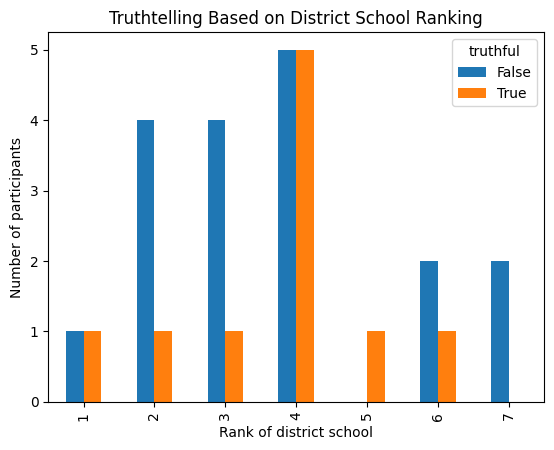

In [350]:
bucket_counts = new_data.groupby('district_school_rank')['partial_truthtell'].value_counts().unstack(fill_value=0)
bucket_counts.plot(kind='bar')
plt.xlabel('Rank of district school')
plt.ylabel('Number of participants')
plt.title('Truthtelling Based on District School Ranking')
plt.legend(title='truthful', labels=['False', 'True'])
plt.show()

In [ ]:
bucket_counts